In [441]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
#from sklearn.grid_search import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.learning_curve import learning_curve

In [4]:
def feature_sex(s):
    if(s =='male'):
        return 0
    else:
        return 1

In [207]:
def feature_embarked(s):
    if(s == 'S'):
        return pd.Series([1,0,0])
    elif(s =='C'):
        return pd.Series([0,1,0])
    elif(s =='Q'):
        return pd.Series([0,0,1])
    else:
        return pd.Series([1,0,0])
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex
def get_ageband(age):
    if(age <= 16):
        return 0
    elif(age >16 and age <= 32):
        return 1
    elif(age >32 and age <=48):
        return 2
    elif(age > 48 and age <= 64):
        return 3
    else:
        return 4
def isAlone(f):
    if(f == 1):
        return 1
    else:
        return 0

In [367]:
titanic_df = pd.read_csv('train.csv')

In [390]:
def convert_df(titanic_df):
    titanic_df['Title'] = titanic_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    titanic_df['Title'] = titanic_df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    titanic_df['Title'] = titanic_df['Title'].replace('Mlle', 'Miss')
    titanic_df['Title'] = titanic_df['Title'].replace('Ms', 'Miss')
    titanic_df['Title'] = titanic_df['Title'].replace('Mme', 'Mrs')
    name_dummies =  pd.get_dummies(titanic_df['Title'])
    titanic_df = titanic_df.join(name_dummies )
    titanic_df.drop(['Title'],axis=1,inplace=True)
    titanic_df[['S','C','Q']] = titanic_df['Embarked'].apply(feature_embarked)
    titanic_df.drop(['Name','Ticket','Cabin','Embarked','S'],axis=1,inplace=True)
    titanic_df['Age'].fillna(titanic_df['Age'].median(axis=0),inplace=True)
    titanic_df['Fare'].fillna(titanic_df['Fare'].median(axis=0),inplace=True)
    #titanic_df['Sex'] = titanic_df['Sex'].apply(feature_sex)
    titanic_df['Sex'] = titanic_df[['Age','Sex']].apply(get_person,axis=1)
    #titanic_df['Age'] = titanic_df['Age'].apply(get_ageband)
    person_dummies_titanic  = pd.get_dummies(titanic_df['Sex'])
    #person_dummies_titanic  = pd.get_dummies(titanic_df['Sex'])
   # person_dummies_titanic.columns = ['Child','Female','Male']
   # person_dummies_titanic.drop(['Male'], axis=1, inplace=True)
    titanic_df = titanic_df.join(person_dummies_titanic)
    titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1
    titanic_df['FamilySize'] = titanic_df['FamilySize'].apply(isAlone)
    titanic_df.drop(['SibSp','Parch'],axis=1,inplace=True)
    titanic_df.drop(['Sex'],axis=1,inplace=True)
    return titanic_df

In [8]:
cr =titanic_df.columns

In [368]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


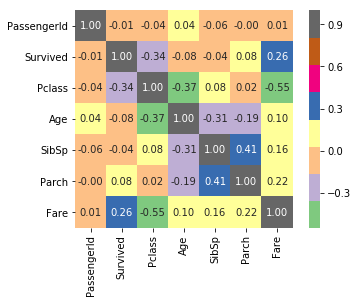

In [22]:
heatmap = sns.heatmap(titanic_df.corr(),cbar=True,cmap="Accent",fmt='.2f',square=True,annot=True)

In [418]:
#model = LogisticRegression(C=100)
#model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05,max_depth=1)
titanic_df = pd.read_csv('train.csv')
#sns.countplot('Embarked', data=titanic_df)
pipeline = Pipeline([
        ('standard_scaler', StandardScaler()),
        ('gbdt',GradientBoostingClassifier(random_state=12))])
        #('rf',RandomForestClassifier())])
params = {'gbdt__n_estimators': [100], 'gbdt__max_depth': [3,5,10], 'gbdt__learning_rate': [0.1],
          'gbdt__subsample':[0.4,0.6,0.8]}
#params={"rf__n_estimators": [1,5,10,100,200],"rf__max_depth":list(range(1,10,2))}
clf = GridSearchCV(pipeline, params,cv=10,return_train_score=True,scoring='accuracy')
#clf = RandomizedSearchCV(pipeline, params,cv=10,scoring='roc_auc')
#clf = GridSearchCV(pipeline, params,cv=10)
titanic_df = convert_df(titanic_df)
x_train, x_test, y_train, y_test = train_test_split(titanic_df.values[:,2:], titanic_df.values[:,1:2], test_size=0.2, random_state=42)
#x_train = titanic_df.values[:,2:]
#y_train = titanic_df.values[:,1:2]
#x_test = titanic_df.values[500:,2:]
#y_test = titanic_df.values[500:,1:2]
c, r = y_train.shape
y_train = y_train.reshape(c,)

In [451]:
log_clf = LogisticRegression()
gbdt_clf = GradientBoostingClassifier()
rf_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)
clf = VotingClassifier(
    estimators=[ ('lr',log_clf),
                ('gbdt',gbdt_clf),
                ('rf',rf_clf),
                ('svm',svm_clf)
                   ],voting='soft'
)
pipeline = Pipeline([
     ('standard_scaler', StandardScaler()),
     ('v',clf)
])
params = {'v__lr__C': [100.0],
          'v__rf__n_estimators': [100,200], 
          'v__rf__max_depth': [3,5],
          'v__gbdt__n_estimators': [100], 
          'v__gbdt__max_depth': [3,5],
          'v__gbdt__learning_rate': [0.1],
          'v__gbdt__subsample':[0.4,0.6,0.8],
          'v__svm__C': [5,10,20],
         }
grid =  GridSearchCV(pipeline,params,cv=10,return_train_score=True,scoring='accuracy')
grid.fit(x_train,y_train)
print('Test set score: {}'.format(grid.score(x_test, y_test)))
print('Best parameters: {}'.format(grid.best_params_))
print('Best cross-validation: {}'.format(grid.best_score_))

Test set score: 0.8044692737430168
Best parameters: {'v__gbdt__learning_rate': 0.1, 'v__gbdt__max_depth': 5, 'v__gbdt__n_estimators': 100, 'v__gbdt__subsample': 0.6, 'v__lr__C': 100.0, 'v__rf__max_depth': 5, 'v__rf__n_estimators': 200, 'v__svm__C': 5}
Best cross-validation: 0.8426966292134831


In [ ]:
pipeline_rf = Pipeline([
        ('standard_scaler', StandardScaler()),
        ('rf',RandomForestClassifier())])
params = {'rf__n_estimators': [50,100,200], 'rf__max_depth': [3,5,10],}
clf1 = GridSearchCV(pipeline_rf, params,cv=10,return_train_score=True,scoring='accuracy')
pipeline_lg = Pipeline([
        ('standard_scaler', StandardScaler()),
        ('lg',LogisticRegression())])
params = {'lg__C': [100,200,300], }
clf2 = GridSearchCV(pipeline_lg,params,cv=10,return_train_score=True,scoring='accuracy')
pipeline_gbdt = Pipeline([
        ('standard_scaler', StandardScaler()),
        ('gbdt',GradientBoostingClassifier())])
params = {'gbdt__n_estimators': [100,200], 'gbdt__max_depth': [3,5,10], 'gbdt__learning_rate': [0.1],
          'gbdt__subsample':[0.4,0.6,0.8]}
clf3 = GridSearchCV(pipeline_gbdt, params,cv=10,return_train_score=True,scoring='accuracy')
clf1.fit(x_train,y_train)
print("RandomForest-------")
print('Test set score: {}'.format(clf1.score(x_test, y_test)))
print('Best parameters: {}'.format(clf1.best_params_))
print('Best cross-validation: {}'.format(clf1.best_score_))
clf2.fit(x_train,y_train)

print("LogistiRegression-------")
print('Test set score: {}'.format(clf2.score(x_test, y_test)))
print('Best parameters: {}'.format(clf2.best_params_))
print('Best cross-validation: {}'.format(clf2.best_score_))
clf3.fit(x_train,y_train)
print("GBDT-------")
print('Test set score: {}'.format(clf3.score(x_test, y_test)))
print('Best parameters: {}'.format(clf3.best_params_))
print('Best cross-validation: {}'.format(clf3.best_score_))


predict_pro1 = clf1.predict_proba(x_test)
predict_pro2 = clf2.predict_proba(x_test)
predict_pro3 = clf3.predict_proba(x_test)

plt.figure(figsize=(8,6))
fpr1, tpr1, thresholds= roc_curve(y_test[:,0],predict_pro1[:,1])
fpr2, tpr2, thresholds= roc_curve(y_test[:,0],predict_pro2[:,1])
fpr3, tpr3, thresholds= roc_curve(y_test[:,0],predict_pro3[:,1])
plt.plot(fpr1, tpr1,label="RndomForest")
plt.plot(fpr2, tpr2,label="LogisticRegression")
plt.plot(fpr3, tpr3,label="GBDT")
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='best')
plt.show()



In [393]:
titanic_df.head()

,PassengerId,Survived,Pclass,Age,Fare,Master,Miss,Mr,Mrs,Rare,C,Q,child,female,male,FamilySize
0,1,0,3,22.0,7.2500,0,0,1,0,0,0,0,0,0,1,0
1,2,1,1,38.0,71.2833,0,0,0,1,0,1,0,0,1,0,0
2,3,1,3,26.0,7.9250,0,1,0,0,0,0,0,0,1,0,1
3,4,1,1,35.0,53.1000,0,0,0,1,0,0,0,0,1,0,0
4,5,0,3,35.0,8.0500,0,0,1,0,0,0,0,0,0,1,1


In [377]:
clf.fit(x_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standard_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbdt', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impuri...        presort='auto', random_state=12, subsample=1.0, verbose=0,
              warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gbdt__n_estimators': [100], 'gbdt__max_depth': [3, 5, 10], 'gbdt__learning_rate': [0.1], 'gbdt__subsample': [0.4, 0.6, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [378]:
print('Test set score: {}'.format(clf.score(x_test, y_test)))
print('Best parameters: {}'.format(clf.best_params_))
print('Best cross-validation: {}'.format(clf.best_score_))

Test set score: 0.8268156424581006
Best parameters: {'gbdt__learning_rate': 0.1, 'gbdt__max_depth': 3, 'gbdt__n_estimators': 100, 'gbdt__subsample': 0.6}
Best cross-validation: 0.8384831460674157


In [345]:
pd.DataFrame.from_dict(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_gbdt__learning_rate,param_gbdt__max_depth,param_gbdt__n_estimators,param_gbdt__subsample,params,rank_test_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.079374,0.000613,0.824438,0.902467,0.1,3,100,0.4,"{'gbdt__learning_rate': 0.1, 'gbdt__max_depth'...",1,...,0.859155,0.895476,0.728571,0.901869,0.914286,0.897196,0.011348,0.000138,0.063686,0.007341


In [363]:
pred=clf.predict(x_test)
predict_pro = clf.predict_proba(x_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test,pred))

             precision    recall  f1-score   support

        0.0       0.85      0.89      0.87       105
        1.0       0.83      0.77      0.80        74

avg / total       0.84      0.84      0.84       179

[[93 12]
 [17 57]]


In [304]:
predict_pro = clf.predict_proba(x_test)
precision,recall, thresholds = precision_recall_curve(y_test[:,0], predict_pro[:,1])
area = auc(recall, precision)

In [347]:
train_sizes, train_scores, test_scores = learning_curve(clf.best_estimator_, X=x_train, y=y_train,train_sizes=np.arange(0.1, 1.1, 0.1), cv=3,scoring="neg_log_loss") 

In [679]:
train_scores

array([[ 1.,  1.,  1.]])

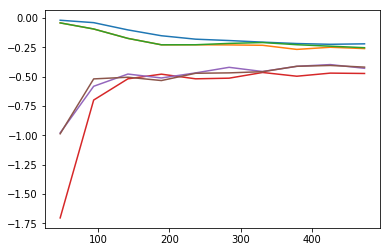

In [348]:
plt.plot(train_sizes,train_scores)
plt.plot(train_sizes,test_scores)

In [351]:
area

0.83222785520349607

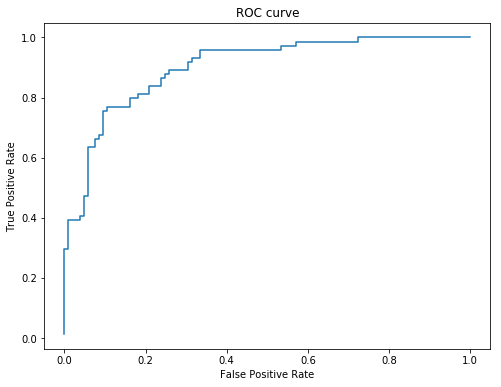

In [452]:
fpr, tpr, thresholds= roc_curve(y_test[:,0],predict_pro[:,1])
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

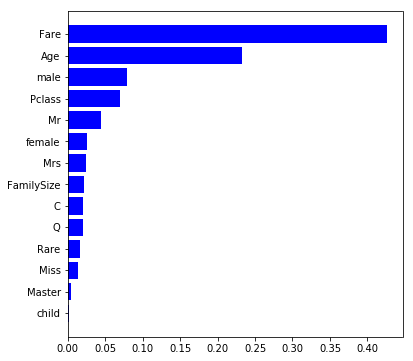

In [379]:
features =titanic_df.columns[2:]
importances = clf.best_estimator_.steps[1][1].feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(6,6))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

In [696]:
predict_mine = np.where(predict_pro[:,1] > 0.8, 1, 0)
print(classification_report(y_test, predict_mine))
print(confusion_matrix(y_test,predict_mine))

             precision    recall  f1-score   support

        0.0       0.81      1.00      0.89       242
        1.0       1.00      0.61      0.76       149

avg / total       0.88      0.85      0.84       391

[[242   0]
 [ 58  91]]


In [707]:
#model = GradientBoostingClassifier(n_estimators=100,max_depth=1,)
pipeline = Pipeline([
        #('standard_scaler', StandardScaler()),
        ('gbdt',GradientBoostingClassifier(learning_rate=0.1,max_depth=1,n_estimators=100))])
#params = {
#    'lg__C' : (1, 10,100),
#}
model = pipeline
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05,max_depth=1)
x_train = titanic_df.values[:,2:]
y_train = titanic_df.values[:,1:2]
c, r = y_train.shape
y_train = y_train.reshape(c,)
model.fit(x_train,y_train)
test_df = pd.read_csv('test.csv')
test_df = convert_df(test_df)
test_df['Fare'].fillna(0,inplace=True)
test_x = test_df.values[:,1:]
#test_y = test_df.values[:,0:1]
class_predict = model.predict(test_x)
test_df = pd.read_csv('test.csv')
test_df = convert_df(test_df)
test_df['Fare'].fillna(0,inplace=True)
test_x = test_df.values[:,1:]
#test_y = test_df.values[:,0:1]
class_predict =model.predict(test_x)

In [632]:
predict_pro = clf.predict_proba(test_x)
predict_mine = np.where(predict_pro[:,1] > 0.8, 1, 0)
zip_data = zip(test_df.values[:,0].astype(int),predict_mine.astype(int))
res = list(zip_data)
res_df = pd.DataFrame(res)
res_df.columns = ["PassengerId","Survived"]
res_df.to_csv("predict_result_data3.csv",index=False)

In [373]:
test_df = pd.read_csv('test.csv')
test_df = convert_df(test_df)
test_x = test_df.values[:,1:]
#test_y = test_df.values[:,0:1]
class_predict =clf.predict(test_x)

In [374]:
zip_data = zip(test_df.values[:,0].astype(int),class_predict.astype(int))
res = list(zip_data)
res_df = pd.DataFrame(res)
res_df.columns = ["PassengerId","Survived"]
res_df.to_csv("predict_result_data.csv",index=False)